# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Введение в анализ данных" </center>

# <center> Лабораторная работа №2. Кластерный анализ. </center>

# Часть 1

В данном задании вам необходимо **самостоятельно** реализовать один из алгоритмов кластеризации.  
По аналогии с классами в scikit-learn, нужно реализовать класс, наследуемый от [Base Estimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html).  
Подробнее про реализацию своих моделей в scikit-learn: [here](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator).  
В классе помимо `__init__()` нужно реализовать два метода:
 - `fit()` - метод, выполняющий кластеризацию данных.
 - `predict()` - метод, определяющий для нового объекта, к какому из кластеров он относится. 
 
Для удобства можно создавать дополнительные методы класса, которые будут вызываться в `fit()` или `predict()`.  <br>
Функции для вычисления расстояний *между объектами* самим реализовывать не нужно, используйте реализации из `scipy`.

In [ ]:
from sklearn.base import BaseEstimator, ClusterMixin

from typing import Callable, Union

import numpy as np
from scipy.spatial import distance
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.datasets import load_iris

class MyDBSCAN(BaseEstimator, ClusterMixin):
    """
    My implementation of clustering algorithm
    """

    metric: Union[str, Callable]
    metric_params: dict
    eps: Union[int, float]
    min_samples: int
    core_sample_coords_: set
    labels_: np.array

    data: np.array
    neighbours: dict
    cluster_storage: list

    def __init__(
        self, 
        metric="euclidean", 
        eps=1, 
        min_samples=3, 
        metric_params={}
        ):
        
        self.metric = metric
        self.metric_params = metric_params
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, data):
        """
        Use data matrix X to compute model parameters
        """
        self.data = data
        self.neighbours = self._get_neighbours(self.data)

        self.core_sample_coords_ = set()
        self.labels_ = np.full(len(self.data), -1, dtype=np.int8)

        cluster_storage = []

        for point in self.neighbours:
            if point in self.core_sample_coords_:
                continue

            if len(self.neighbours[point]) >= self.min_samples:
                self.core_sample_coords_.add(point)

                new_cluster = self._create_cluster(point, self.neighbours[point])
                cluster_storage.append(new_cluster)

        for cluster_num, cluster in enumerate(cluster_storage):
            for point in cluster:
                self.labels_[point] = cluster_num

    def predict(self, data):
        """
        Using computed model parameters predict cluster
        for all objects from matrix X
        """

        if self.metric == "precomputed":
            raise ValueError("Distance matrix can't be used for prediction.")

        labels = np.full(len(data), -1, dtype=np.int8)

        neighbours = self._get_neighbours(data)

        for idx in neighbours:
            if len(neighbours[idx]) > 0:
                labels[idx] = self.labels_[neighbours[idx][0]]

        return labels

    def _get_neighbours(self, other):
        distance_matrix = np.array([], dtype=np.float16)
        neighbours = {}

        if self.metric == "precomputed":
            distance_matrix = self.data

        elif callable(self.metric) or self.metric in dir(distance):
            distance_matrix = distance.cdist(
                other, 
                self.data, 
                self.metric, 
                **self.metric_params
                )

        for idx, row in enumerate(distance_matrix):
            neighbours[idx] = np.where(row <= self.eps)[0]

        return neighbours

    def _create_cluster(self, point, neighbours):
        """
        Making new cluster.
        """

        cluster = [point]

        for neighbour in neighbours:
            if neighbour not in self.core_sample_coords_:

                if len(self.neighbours[neighbour]) >= self.min_samples:
                    self.core_sample_coords_.add(neighbour)

                    expanded_cluster = self._create_cluster(
                        neighbour,
                        self.neighbours[neighbour]
                    )

                    cluster.extend(expanded_cluster)

                else:
                    cluster.append(neighbour)

        return cluster


### Вариант №1  

Алгоритм агломеративной кластеризации.  
  
Параметры: 
- **metric:** Функция расстояния между объектами. Должны поддерживаться метрики из `scipy.spatial.distance`, самописные функции (callable) и предрассчитанная матрица расстояний.  
- **linkage:** Расстояние между кластерами. Должны поддерживаться Single, Complete и Average.  
- **n_clusters:** Число кластеров. По умолчанию должно быть None. 

  
Атрибуты:  
- **z_:** матрица объединений, аналогичная той, что возвращает `linkage()` из `scipy.cluster.hierarchy`;
- **data_:** копия данных, использованных для кластеризации;  
- **labels_:** метки кластеров для каждого объекта.   
  
Дополнительно нужно реализовать метод `get_labels()` для вычисления **labels_**, он должен быть аналогичен [fcluster()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html). <br>
В случае, если **n_clusters** не None, то после вычисления матрицы **z_** в методе `fit()` должен быть вызван `get_labels()` с соответствующими параметрами, и вычислены **labels_**. В других случаях метод `fit()` только вычисляет матрицу **z_**, для вычисления **labels_** нужно явно вызывать `get_labels()`. 
  
Метод `predict()`:  Кластер для нового объекта определяется по методу, заданному в **linkage**.  <br>
**Note:** Метод `predict()` не выполняется в случае, когда **metric** - это матрица расстояний.

### Вариант №2

Алгоритм Dbscan.  
  
Параметры: 
- **eps:** радиус окрестности $\varepsilon$;  
- **min_samples:** минимальное число объектов в окрестности $\varepsilon$ для основных точек;  
- **metric:** функция расстояния между объектами. Должны поддерживаться метрики из `scipy.spatial.distance`, самописные функции (callable) и предрассчитанная матрица расстояний.   
- **metric_params:** параметры функции расстояния, если такие есть. 
  
Атрибуты:  
- **core\_sample\_coords\_:** - векторы основных точек;
- **labels_:** метки кластеров для каждого объекта.
  
Метод `predict()`:  Для нового объекта вычисляется число основных точек из каждого кластера, попавших в окрестность $\varepsilon$. Объект определяется в кластер с наибольшим числом таких точек.  
**Note:** Метод `predict()` не выполняется в случае, когда **metric** - это матрица расстояний. 

### Вариант №3

Алгоритм K-Means.  
  
Параметры: 
- **k:** число центров (кластеров);
- **init**: метод инициализации центров - random или kmeans++;
- **n_init**: число запусков алгоритма;
- **max_iter:** максимальное число итераций;  
- **tol:** минимальное значение изменения целевой функции.  
  
Атрибуты:  
- **inertia_:** Итоговое значение целевой функции;
- **cluster\_centers\_:** центры кластеров - ndarray of shape (n_clusters, n_features);
- **labels_:** метки кластеров для каждого объекта.  
  
Метод `predict()`:  Новый объект определяется в кластер, центр которого расположен ближе всех к этому объекту. 

### Тестирование 

Вашу реализацию необходимо сравнить с питоновской реализацией алгоритма из `sklearn` или `scipy`. Результаты кластеризации должны совпадать.  
Также необходимо сравнить скорость работы вашей реализации и питоновской (это нормально, если ваша реализация будет медленнее).  
Сравнение необходимо выполнить на наборе данных iris.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
iris = load_iris()
X = iris.data # использовать для кластеризации
y = iris.target # истинные метки цветков

In [ ]:
X_iris = pd.DataFrame(X, columns=iris.feature_names)
X_iris['class'] = [iris.target_names[i] for i in y]

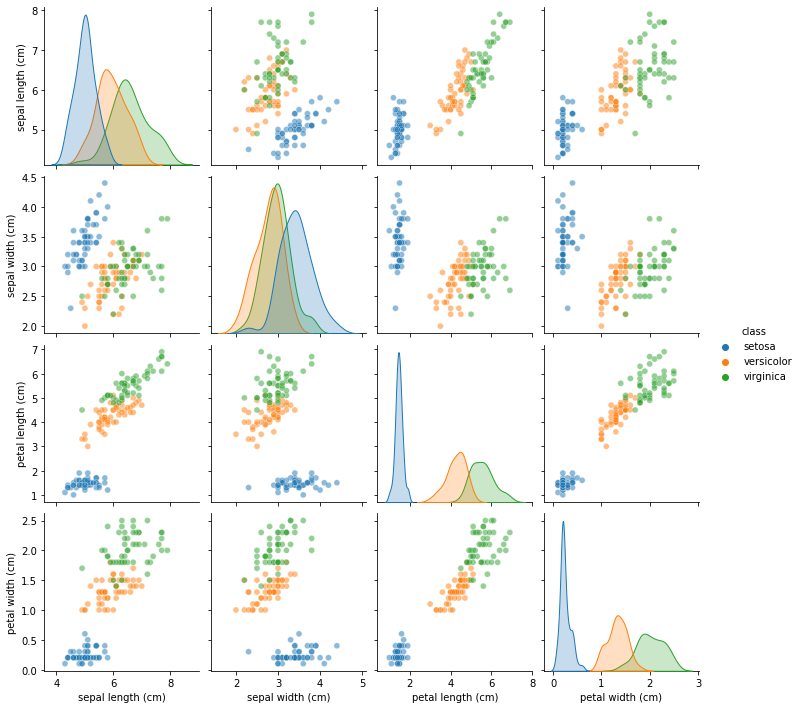

In [ ]:
sns.pairplot(X_iris, hue='class', plot_kws={'alpha':0.5}, vars=iris.feature_names)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=1, min_samples=3, metric="euclidean")
dbscan_hm = MyDBSCAN(eps=1, min_samples=3, metric="euclidean")

In [ ]:
%%timeit -n200 -r 20
dbscan.fit(X)
dbscan.labels_

200 loops, best of 20: 2.16 ms per loop


In [ ]:
%%timeit -n200 -r 20
dbscan_hm.fit(X)
dbscan_hm.labels_

200 loops, best of 20: 2.12 ms per loop


In [ ]:
assert all(dbscan.labels_ == dbscan_hm.labels_), "Clustering results are not identical."

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(dbscan_hm.labels_.reshape(-1, 1), y)

0.3333333333333333

##### Заключение
- Результаты работы оригинальной версии совпадают с моей
- Обе выделяют всего 2 кластера с этими параметрами
- Моя версия работает примерно с такой же скоростью, что и оригинальная (дальше более быстрая версия)

### Бонусное  
  
Дополнительно вы можете поработать над эффективностью алгоритма по скорости и памяти, добавить поддержку многопоточности, или расширить базовый функционал.

In [ ]:
%load_ext cython

In [ ]:
%%cython
from sklearn.base import BaseEstimator, ClusterMixin

from typing import Callable, Union

import numpy as np
from scipy.spatial import distance
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN

cimport numpy

cdef dict neighbours
cdef list cluster_storage
cdef int min_samples

class MyDBSCAN(BaseEstimator, ClusterMixin):
    """
    My implementation of clustering algorithm
    """

    metric: Union[str, Callable]
    metric_params: dict
    eps: Union[int, float]
    core_sample_coords_: set

    def __init__(
        self, 
        metric="euclidean", 
        eps=1, 
        int min_samples=3, 
        dict metric_params={}
        ):
        
        self.metric = metric
        self.metric_params = metric_params
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, numpy.ndarray[numpy.float_t, ndim=2] data):
        """
        Use data matrix X to compute model parameters
        """
        cdef dict neighbours
        cdef list cluster_storage
        cdef numpy.ndarray[numpy.int_t] labels

        self.data = data
        self.neighbours = self._get_neighbours(self.data)

        self.core_sample_coords_ = set()

        labels_ = np.full(len(self.data), -1)
        self.labels_ = labels_

        cluster_storage = []

        for point in self.neighbours:
            if point in self.core_sample_coords_:
                continue

            if len(self.neighbours[point]) >= self.min_samples:
                self.core_sample_coords_.add(point)

                new_cluster = self._create_cluster(point, self.neighbours[point])
                cluster_storage.append(new_cluster)

        for cluster_num, cluster in enumerate(cluster_storage):
            for point in cluster:
                self.labels_[point] = cluster_num

    def predict(self, numpy.ndarray[numpy.float_t, ndim=2] arr):
        """
        Using computed model parameters predict cluster
        for all objects from matrix X
        """

        cdef numpy.ndarray[numpy.int_t] labels

        if self.metric == "precomputed":
            raise ValueError("Distance matrix can't be used for prediction.")

        labels = np.full(len(arr), -1)

        neighbours = self._get_neighbours(arr)

        for idx in neighbours:
            if len(neighbours[idx]) > 0:
                labels[idx] = self.labels_[neighbours[idx][0]]

        return labels

    def _get_neighbours(self, numpy.ndarray[numpy.float_t, ndim=2] other):
        cdef numpy.ndarray[numpy.float_t, ndim=2] distance_matrix
        neighbours = {}

        if self.metric == "precomputed":
            distance_matrix = self.data

        elif callable(self.metric) or self.metric in dir(distance):
            distance_matrix = distance.cdist(
                other, 
                self.data, 
                self.metric, 
                **self.metric_params
                )

        for idx, row in enumerate(distance_matrix):
            neighbours[idx] = np.where(row <= self.eps)[0]

        return neighbours

    def _create_cluster(self, numpy.int_t point, neighbours):
        """
        Making new cluster.
        """

        cluster = [point]

        for neighbour in neighbours:
            if neighbour not in self.core_sample_coords_:

                if len(self.neighbours[neighbour]) >= self.min_samples:
                    self.core_sample_coords_.add(neighbour)

                    expanded_cluster = self._create_cluster(
                        neighbour,
                        self.neighbours[neighbour]
                    )

                    cluster.extend(expanded_cluster)

                else:
                    cluster.append(neighbour)

        return cluster


iris = load_iris()
X = iris.data # использовать для кластеризации

dbscan = DBSCAN(eps=1, min_samples=3, metric="euclidean")
dbscan_hm = MyDBSCAN(eps=1, min_samples=3, metric="euclidean")

def db_fit(model):
    model.fit(X)

import time

start = time.time()
db_fit(dbscan)
print("Original:", time.time() - start)

start = time.time()
db_fit(dbscan_hm)
print("Handmade:", time.time() - start)

assert all(dbscan.labels_ == dbscan_hm.labels_), "Clustering results are not identical."

Original: 0.0027534961700439453
Handmade: 0.002295970916748047


##### Заключение
- Моя (немножко кривая) реализация DBSCAN на Cython
 ещё чуть быстрее, чем версия из sklearn (иногда до 2x быстрее)

### Распределение по вариантам

In [ ]:
pd.set_option('display.max_rows', 50)

In [ ]:
Vars = pd.read_csv('Vars.txt', sep='\t')

#### Вариант №1

In [ ]:
Vars[Vars.iloc[:,2] == 1]

,ФИО,Группа,Вариант №
0,Бакурский Андрей Сергеевич,1 ИАД,1
2,Бекина Светлана Сергеевна,1 ИАД,1
3,Бекусов Михаил Александрович,1 ИАД,1
9,Конина Татьяна Дмитриевна,1 ИАД,1
11,Лукичева Полина Александровна,1 ИАД,1
12,Моничева Арина Александровна,1 ИАД,1
22,Трухин Егор Сергеевич,1 ИАД,1
23,Шарунов Евгений Александрович,1 ИАД,1
24,Шатилов Виктор Алексеевич,1 ИАД,1
27,Астахова Елизавета Евгеньевна,2 ИАД,1


#### Вариант №2

In [ ]:
Vars[Vars.iloc[:,2] == 2]

,ФИО,Группа,Вариант №
1,Балаян Роман Каренович,1 ИАД,2
5,Даняев Артем Андреевич,1 ИАД,2
7,Ешманов Павел Андреевич,1 ИАД,2
10,Костин Андрей Олегович,1 ИАД,2
15,Ожиганова Полина Максимовна,1 ИАД,2
17,Сапожников Андрей Михайлович,1 ИАД,2
18,Семаев Никита Юрьевич,1 ИАД,2
21,Суворов Артём Андреевич,1 ИАД,2
25,Южаков Максим Вячеславович,1 ИАД,2
28,Бабий Александр Сергеевич,2 ИАД,2


#### Вариант №3

In [ ]:
Vars[Vars.iloc[:,2] == 3]

,ФИО,Группа,Вариант №
4,Боряев Сергей Сергеевич,1 ИАД,3
6,Дыряев Даниил Александрович,1 ИАД,3
8,Игумнова Наталья Дмитриевна,1 ИАД,3
13,Мурзинов Михаил Денисович,1 ИАД,3
14,Николаева Олеся Игоревна,1 ИАД,3
16,Османов Ислам Рамилевич,1 ИАД,3
19,Смирнов Григорий Андреевич,1 ИАД,3
20,Стифеев Никита Владимирович,1 ИАД,3
26,Арбузова Екатерина Михайловна,2 ИАД,3
31,Варгин Дмитрий Александрович,2 ИАД,3


# Часть 2

In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import kneighbors_graph
from scipy.spatial import distance

В данном задании вам предлагается проанализировать набор данных по различным городам США. Каждый город характеризуется следующими признаками:

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
data_desc = pd.read_csv('Data_Description.txt', sep=':')
data_desc

,Attribute,Description
0,Place,"City, state (postal code)"
1,Climate & Terrain,"Very hot and very cold months, seasonal temperature variation, heating- and cooling-degree days, freezing days, zero-degree days, ninety-degree days."
2,Housing,"Utility bills, property taxes, mortgage payments."
3,Health Care & Environment,"Per capita physicians, teaching hospitals, medical schools, cardiac rehabilitation centers, comprehensive cancer treatment centers, hospices, insurance/hospitalization costs index, flouridation of drinking water, air pollution."
4,Crime,"Violent crime rate, property crime rate."
5,Transportation,"Daily commute, public transportation, Interstate highways, air service, passenger rail service."
6,Education,"Pupil/teacher ratio in the public K-12 system, effort index in K-12, accademic options in higher education."
7,The Arts,"Museums, fine arts and public radio stations, public television stations, universities offering a degree or degrees in the arts, symphony orchestras, theatres, opera companies, dance companies, public libraries."
8,Recreation,"Good restaurants, public golf courses, certified lanes for tenpin bowling, movie theatres, zoos, aquariums, family theme parks, sanctioned automobile race tracks, pari-mutuel betting attractions, major- and minor- league professional sports teams, NCAA Division I football and basketball teams, miles of ocean or Great Lakes coastline, inland water, national forests, national parks, or national wildlife refuges, Consolidated Metropolitan Statistical Area access."
9,Economics,"Average household income adjusted for taxes and living costs, income growth, job growth."


### Notes:   
* Для всех признаков, кроме трех, чем выше значение - тем лучше. Для признаков `Housing` и `Crime` - наоборот.
* Признак `Population`- статистический признак, не имеющий интерпретации как “лучше-хуже”.
* Признак `Place` - уникальный идентификатор объекта (города), он не должен использоваться при кластеризации.
* Также в данных присутствуют географические координаты городов - `Longitude` и `Latitude`. Их также не следует использовать при кластеризации данных.

In [2]:
data = pd.read_csv('Data.txt', sep=' ')
data

,Place,Climate,HousingCost,HlthCare,Crime,Transp,Educ,Arts,Recreat,Econ,Long,Lat,Pop
0,"Abilene,TX",521,6200,237,923,4031,2757,996,1405,7633,-99.6890,32.5590,110932
1,"Akron,OH",575,8138,1656,886,4883,2438,5564,2632,4350,-81.5180,41.0850,660328
2,"Albany,GA",468,7339,618,970,2531,2560,237,859,5250,-84.1580,31.5750,112402
3,"Albany-Schenectady-Troy,NY",476,7908,1431,610,6883,3399,4655,1617,5864,-73.7983,42.7327,835880
4,"Albuquerque,NM",659,8393,1853,1483,6558,3026,4496,2612,5727,-106.6500,35.0830,419700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,"Worcester,MA",562,8715,1805,680,3643,3299,1784,910,5040,-71.7950,42.2720,402918
325,"Yakima,WA",535,6440,317,1106,3731,2491,996,2140,4986,-120.5130,46.5950,172508
326,"York,PA",540,8371,713,440,2267,2903,1022,842,4946,-76.7280,39.9600,381255
327,"Youngstown-Warren,OH",570,7021,1097,938,3374,2920,2797,1327,3894,-80.7290,41.1700,531350


## Задания: 

1. Выполните необходимую предобработку данных. Перед кластеризацией исключите из данных признаки `Place`, `Long` и `Lat`.  
  
  
2. Выполните кластеризацию иерархическим методом.  
Рассмотрите различные расстояния между объектами. Определите, какие следует использовать при кластеризации.  
Выполните кластеризацию с различными расстояниями между кластерами. Сравните результаты, сделайте выводы. 
  
  
3. Выполните кластеризацию методом Dbscan. Используйте расстояния между объектами, определенные в предыдущем пункте.  
Реализуйте эвристику (см. лекции) для выбора параметров алгоритма. Подберите подходящие параметры алгоритма.  
  
  
4. Выполните кластеризацию методом kmeans. Определите наилучшее (на ваш взгляд) число кластеров.  
  
  
5. (Бонусное) Выполните кластеризацию другими методами. Например, [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) или алгоритмы, [реализованные](https://scikit-learn.org/stable/modules/clustering.html) в scikit-learn.  
  
  
6. В результате выполнения предыдущих пунктов вы должны получить 4 или больше разбиений объектов (по одному на каждый метод). Сравните их между собой, сделайте выводы о сходствах и различиях.  
Оцените результаты каждой кластеризации, используя метрики, рассмотренные на занятиях (Silhouette и прочие).  
  
  
7. Выберите одно разбиение, наиболее подходящее на ваш взгляд. Предложите интерпретацию полученным кластерам или покажите, что этого сделать нельзя.  
  
  
8. Оцените, как полученные кластеры распределены географически.  
Оцените, как полученные кластеры распределены по штатам. Можно ли выделить какую-то зависимость (территориальную или для штатов)?  
(Бонусное) [Провизуализируйте](https://python-visualization.github.io/folium/quickstart.html) распределение на карте США.

### Предобработка

In [3]:
from sklearn import metrics

In [4]:
processed_data = data.drop(["Place", "Long", "Lat"], axis=1)
processed_data.head()

,Climate,HousingCost,HlthCare,Crime,Transp,Educ,Arts,Recreat,Econ,Pop
0,521,6200,237,923,4031,2757,996,1405,7633,110932
1,575,8138,1656,886,4883,2438,5564,2632,4350,660328
2,468,7339,618,970,2531,2560,237,859,5250,112402
3,476,7908,1431,610,6883,3399,4655,1617,5864,835880
4,659,8393,1853,1483,6558,3026,4496,2612,5727,419700


In [5]:
scaler = StandardScaler()

In [6]:
scaled_data = pd.DataFrame(scaler.fit_transform(processed_data), columns=processed_data.columns)
scaled_data.head()

,Climate,HousingCost,HlthCare,Crime,Transp,Educ,Arts,Recreat,Econ,Pop
0,-0.147006,-0.901297,-0.947340,-0.106712,-0.123592,-0.180726,-0.464893,-0.546646,1.946433,-0.460990
1,0.300664,-0.087570,0.469568,-0.210467,0.464411,-1.176652,0.520604,0.974442,-1.085467,0.154950
2,-0.586386,-0.423054,-0.566902,0.025084,-1.158809,-0.795765,-0.628640,-1.223512,-0.254304,-0.459342
3,-0.520064,-0.184142,0.244900,-0.984419,1.844699,1.823613,0.324497,-0.283834,0.312735,0.351765
4,0.997040,0.019500,0.666278,1.463626,1.620402,0.659098,0.290194,0.949648,0.186213,-0.114824


### Иерархическая кластеризация

#### Полезные функции

In [7]:
def count_cluster_samples(labels):
    unique, counts = np.unique(clusters, return_counts=True)
    print(dict(zip(unique, counts)))

In [8]:
def plot_samples(data, clusters=None):
    if clusters is not None:
        return sns.scatterplot(
          x=data[:, 0], 
          y=data[:, 1], 
          c=clusters,
          cmap="rainbow"
          )
    else:
        return sns.scatterplot(
          x=data[:, 0],
          y=data[:, 1],
        )

In [9]:
from collections import namedtuple


def compute_metrics(X, labels):
    silhouette = metrics.silhouette_score(X, labels)
    davies = metrics.davies_bouldin_score(X, labels)
    calinski = metrics.calinski_harabasz_score(X, labels)

    print(f"Silhouette: {silhouette}")
    print(f"Davies-Bouldin: {davies}")
    print(f"Calinski-Harabasz: {calinski}")

    Metrics = namedtuple("Metrics", ["silhouette", "davies", "calinski"])

    return Metrics(silhouette, davies, calinski)

#### Исследование данных и определение оптимального количества кластеров

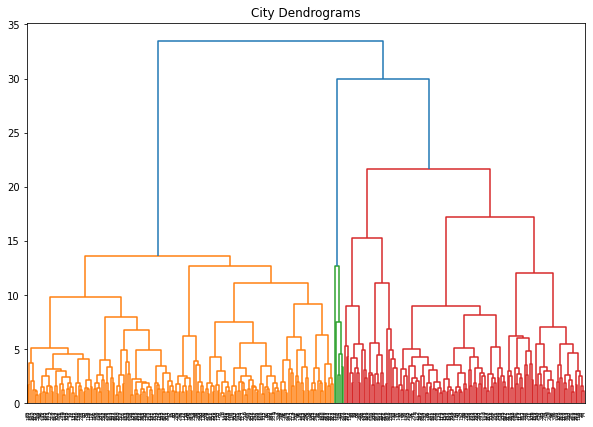

In [14]:
plt.figure(figsize=(10, 7))
plt.title("City Dendrograms")
dend = sch.dendrogram(sch.linkage(scaled_data, method='ward'))

In [10]:
data_embedded = TSNE(n_components=2).fit_transform(scaled_data.values)

<AxesSubplot:>

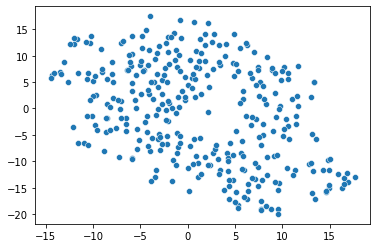

In [11]:
plot_samples(data_embedded)

# NB! Размерность снижена достаточно сильно,
# поэтому визуализация может быть не совсем репрезентативна

In [11]:
metric_stats = {}

#### Experiments with `ward & euclidean` distances

In [15]:
knn_graph = kneighbors_graph(scaled_data, 30, include_self=False)

{0: 142, 1: 181, 2: 6}


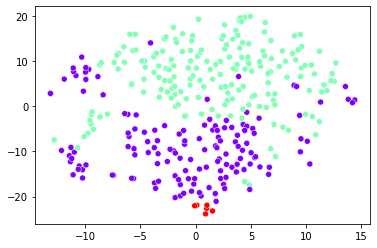

In [16]:
clusters = AgglomerativeClustering(
    n_clusters=3, 
    linkage="ward", 
    affinity="euclidean"
    ).fit_predict(scaled_data)

count_cluster_samples(clusters)
plot_samples(data_embedded, clusters=clusters)

In [17]:
metric_stats["agglomerative_ward"] = compute_metrics(scaled_data, clusters)

Silhouette: 0.1740790530715999
Davies-Bouldin: 1.6386724367395287
Calinski-Harabasz: 72.21532753341644


{0: 142, 1: 181, 2: 6}


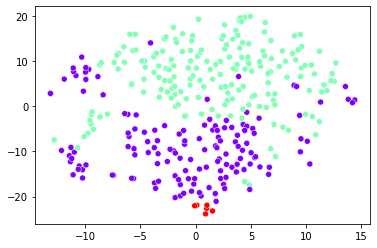

In [18]:
clusters = AgglomerativeClustering(
    n_clusters=3, 
    linkage="ward", 
    affinity="euclidean",
    connectivity=knn_graph
    ).fit_predict(scaled_data)

count_cluster_samples(clusters)
plot_samples(data_embedded, clusters=clusters)

In [19]:
# 3rd cluster samples
processed_data.iloc[np.where(clusters == 2)[0], :]

,Climate,HousingCost,HlthCare,Crime,Transp,Educ,Arts,Recreat,Econ,Pop
42,623,11609,5301,1215,6801,3479,21042,3066,6363,2805911
64,514,10913,5766,1034,7742,3486,24846,2856,5205,6060387
178,885,13868,5153,1960,4345,3195,23567,3948,5316,7477503
212,638,13358,7850,2498,8625,2984,56745,3579,5338,8274961
233,630,8310,5158,1059,5903,3781,17270,1979,5638,4716818
313,631,13724,4361,1317,8236,3635,21701,1578,6072,3250822


{0: 148, 1: 181}


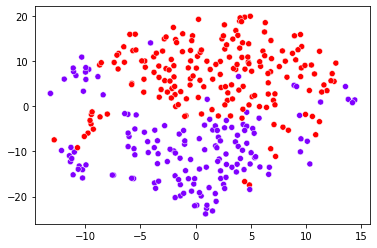

In [20]:
clusters = AgglomerativeClustering(
    n_clusters=2, 
    linkage="ward", 
    affinity="euclidean",
    connectivity=knn_graph
    ).fit_predict(scaled_data)

count_cluster_samples(clusters)
plot_samples(data_embedded, clusters=clusters)

{0: 148, 1: 181}


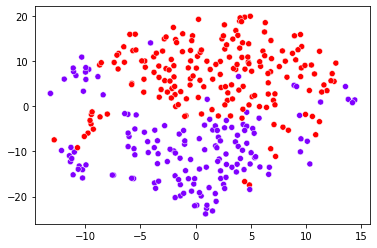

In [21]:
clusters = AgglomerativeClustering(
    n_clusters=2, 
    linkage="ward", 
    affinity="euclidean"
    ).fit_predict(scaled_data)

count_cluster_samples(clusters)
plot_samples(data_embedded, clusters=clusters)

##### Заключение
- Результаты кластеризации с использованием `knn` графа с 30 соседями идентичны результатам без использования `knn` графа для `ward & euclidean`
- Третий кластер (с использованием `ward & euclidean` представлен только 6 наблюдениями, что похоже на данные из дендрограммы (там ведь тоже использован `ward`)
- Мы могли бы снизить количество кластеров до 2, убрав 1, но стоит ли?
- Может, эти 6 наблюдений -- выбросы?

#### Experiments with `complete` linkage

In [22]:
# Manhattan is equal to L1 and Euclidean is equal to L2
# Thus, we'll use only Manhattan and Euclidean
# for efficiency and readability purposes

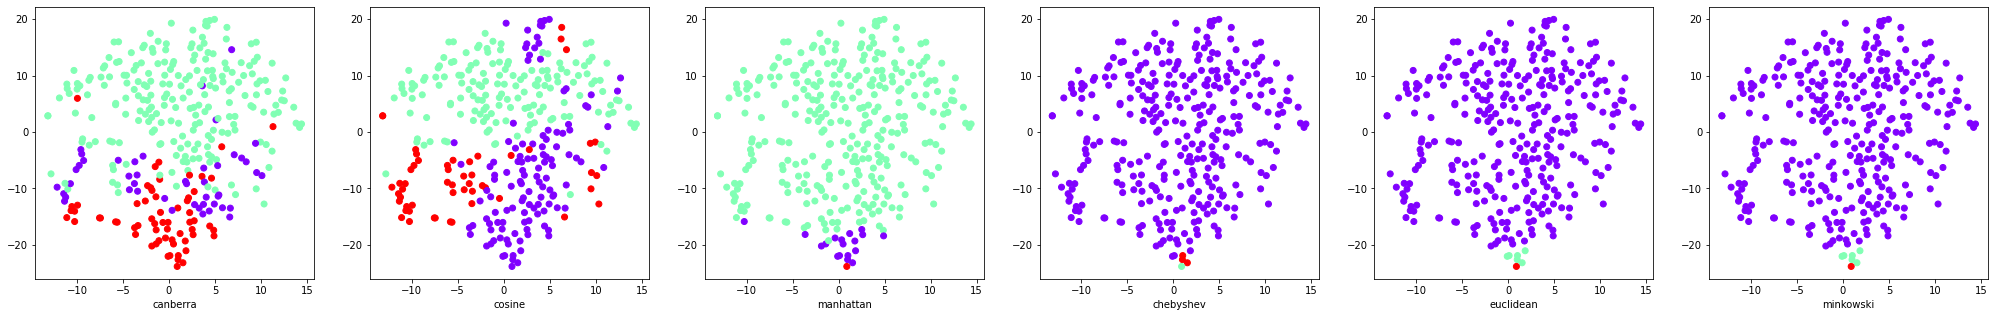

In [23]:
fig, axes = plt.subplots(ncols=6, figsize=(35, 5))


for idx, metric in enumerate(
    {
        "euclidean", 
        "cosine", 
        "manhattan",
        "minkowski",
        "chebyshev", 
        "canberra"
     }
    ):
  
    clusters = AgglomerativeClustering(
      n_clusters=3,
      linkage="complete", 
      affinity=metric
      ).fit_predict(scaled_data)

    axes[idx].set_xlabel(metric)
    axes[idx].scatter(x=data_embedded[:, 0], y=data_embedded[:, 1], c=clusters, cmap="rainbow")

In [24]:
clusters = AgglomerativeClustering(
    n_clusters=3,
    linkage="complete", 
    affinity="cosine"
    ).fit_predict(scaled_data)

metric_stats["agglomerative_complete_cosine"] = compute_metrics(scaled_data, clusters)

Silhouette: 0.13931449234623647
Davies-Bouldin: 2.339718960788736
Calinski-Harabasz: 43.342180410474114


#### Experiments with `single` linkage

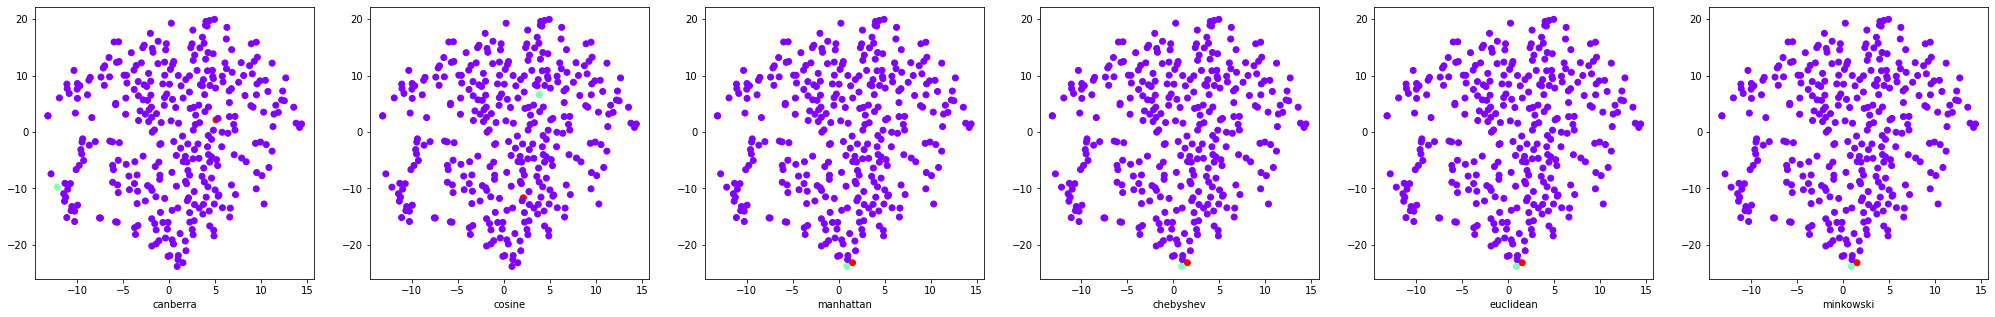

In [25]:
fig, axes = plt.subplots(ncols=6, figsize=(35, 5))


for idx, metric in enumerate(
    {
        "euclidean", 
        "cosine", 
        "manhattan",
        "minkowski",
        "chebyshev",
        "canberra"
    }
     ):
  
    clusters = AgglomerativeClustering(
      n_clusters=3,
      linkage="single", 
      affinity=metric
      ).fit_predict(scaled_data)

    axes[idx].set_xlabel(metric)
    axes[idx].scatter(x=data_embedded[:, 0], y=data_embedded[:, 1], c=clusters, cmap="rainbow")

#### Experiments with `average` linkage

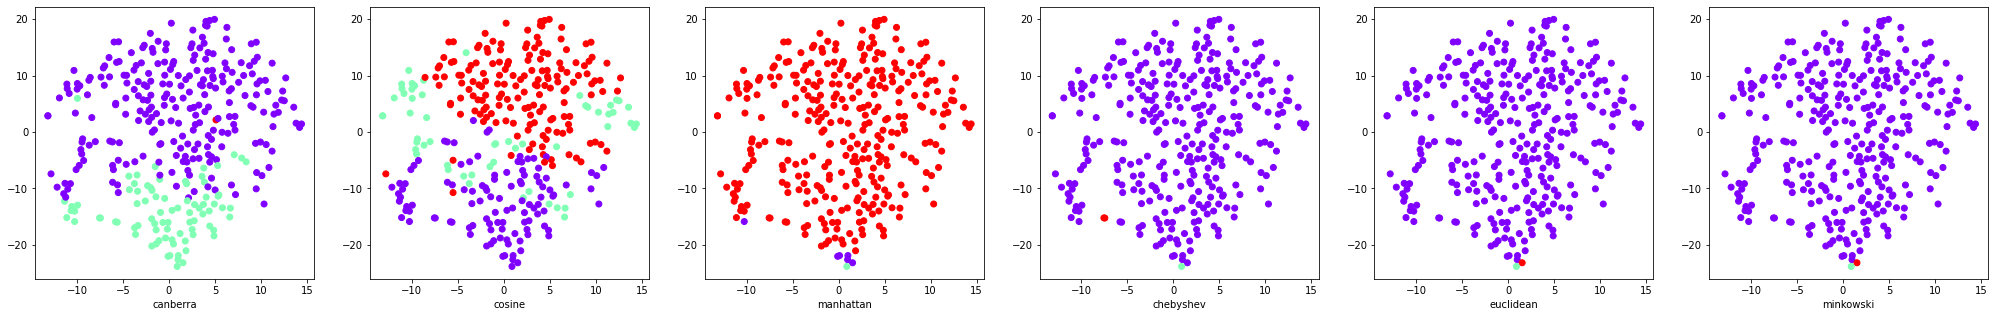

In [26]:
fig, axes = plt.subplots(ncols=6, figsize=(35, 5))


for idx, metric in enumerate(
    {
        "euclidean", 
        "cosine", 
        "manhattan",
        "minkowski",
        "chebyshev",
        "canberra"
    }
    ):
  
    clusters = AgglomerativeClustering(
      n_clusters=3,
      linkage="average", 
      affinity=metric
      ).fit_predict(scaled_data)

    axes[idx].set_xlabel(metric)
    axes[idx].scatter(x=data_embedded[:, 0], y=data_embedded[:, 1], c=clusters, cmap="rainbow")

In [27]:
clusters = AgglomerativeClustering(
    n_clusters=3,
    linkage="average", 
    affinity="cosine"
    ).fit_predict(scaled_data)

metric_stats["agglomerative_average_cosine"] = compute_metrics(scaled_data, clusters)

Silhouette: 0.08797497634337614
Davies-Bouldin: 2.0850910072225193
Calinski-Harabasz: 53.813409016452525


##### Заключение
Выводы:
- Использование кратчайших расстояний между кластерами (`single` linkage) достаточно бесполезно для этого датасета
- Использование `average & canberra` при 3х кластерах выделяет буквально один сэмпл для одного из кластеров, хотя с остальным он справился достаточно неплохо
- Среди полезных расстояний между объектами можно выделить здесь только косинусное расстояние в связке `complete & cosine` и `average & cosine` и `canberra` в связке `complete & canberra`.
- Работа последнего достаточно сильно отличается от остальных, но результаты выглядят адекватно

Расстояния, которые могут быть использованы для кластеризации этого датасета:
1. Пара расстояний `ward & euclidean` хорошо разбивает данные на кластеры, но 3й выделенный кластер может быть интерпретирован как выбросы
2. Пары `complete & cosine` и `average & cosine` тоже могут быть использованы для кластеризации, но стоит учитывать, что косинусное расстояние не учитывает абсолютное расстояние между наблюдениями в векторном пространстве, а только угол между ними, что позволяет выявлять тенденции в данных. 

Вывод по используемым расстояниям:
- Использование первой пары расстояний либо оставшихся двух зависит от того, какую информацию мы хотим получить на основе этих данных

### DBSCAN

Text(0, 0.5, 'Distance')

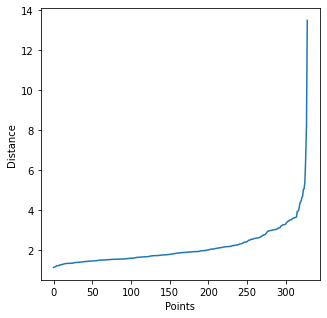

In [28]:
# Heuristics for euclidean distance
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=11, metric="euclidean")
neighbors = nearest_neighbors.fit(scaled_data)

distances, indices = neighbors.kneighbors(scaled_data)
distances = np.sort(distances[:,10], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

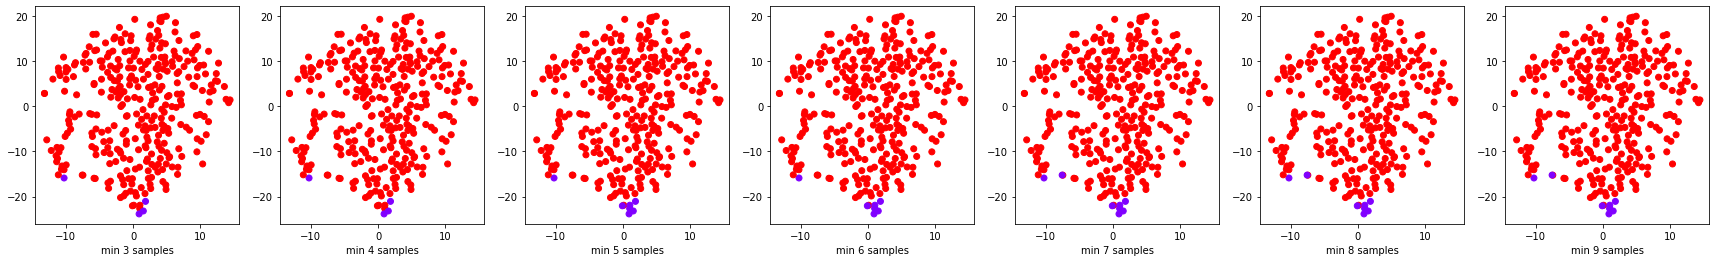

In [29]:
# Using optimal eps from the plot
fig, axes = plt.subplots(ncols=7, figsize=(30, 4))


for idx, i in enumerate(range(3, 10)):
    dbscan = DBSCAN(metric="euclidean", eps=3.7, min_samples=i)
    clusters = dbscan.fit_predict(scaled_data)

    axes[idx].set_xlabel(f"min {i} samples")
    axes[idx].scatter(x=data_embedded[:, 0], y=data_embedded[:, 1], c=clusters, cmap="rainbow")

In [30]:
dbscan = DBSCAN(metric="euclidean", eps=3.7, min_samples=6)
clusters = dbscan.fit_predict(scaled_data)

metric_stats["dbscan_euclidean"] = compute_metrics(scaled_data, clusters)

Silhouette: 0.6129352430409912
Davies-Bouldin: 0.8082913537210814
Calinski-Harabasz: 66.79375705838629


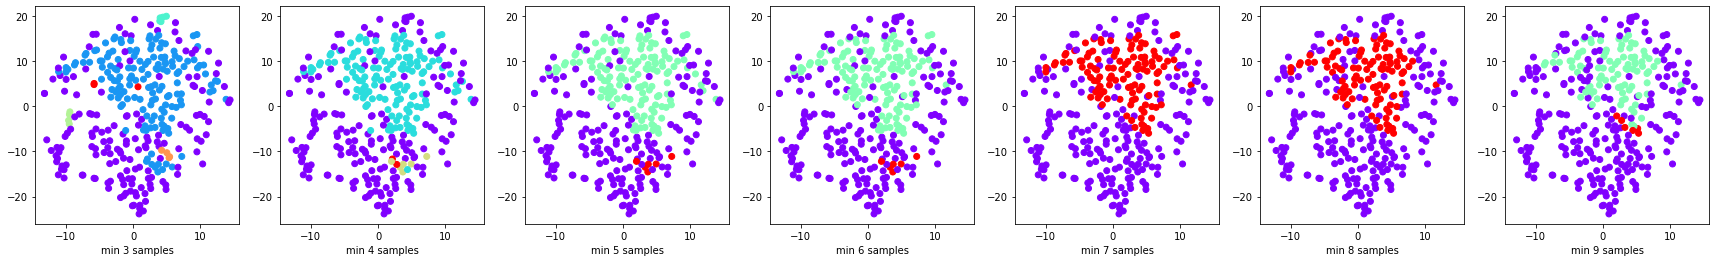

In [31]:
# Using hand-picked eps
fig, axes = plt.subplots(ncols=7, figsize=(30, 4))


for idx, i in enumerate(range(3, 10)):
    dbscan = DBSCAN(metric="euclidean", eps=1.3, min_samples=i)
    clusters = dbscan.fit_predict(scaled_data)

    axes[idx].set_xlabel(f"min {i} samples")
    axes[idx].scatter(x=data_embedded[:, 0], y=data_embedded[:, 1], c=clusters, cmap="rainbow")

Text(0, 0.5, 'Distance')

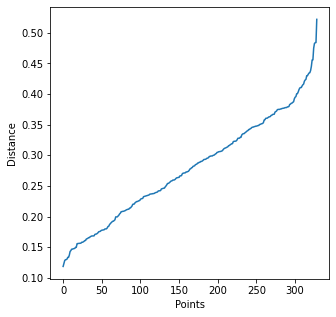

In [32]:
# Heuristics for cosine distance
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=11, metric="cosine")
neighbors = nearest_neighbors.fit(scaled_data)
distances, indices = neighbors.kneighbors(scaled_data)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

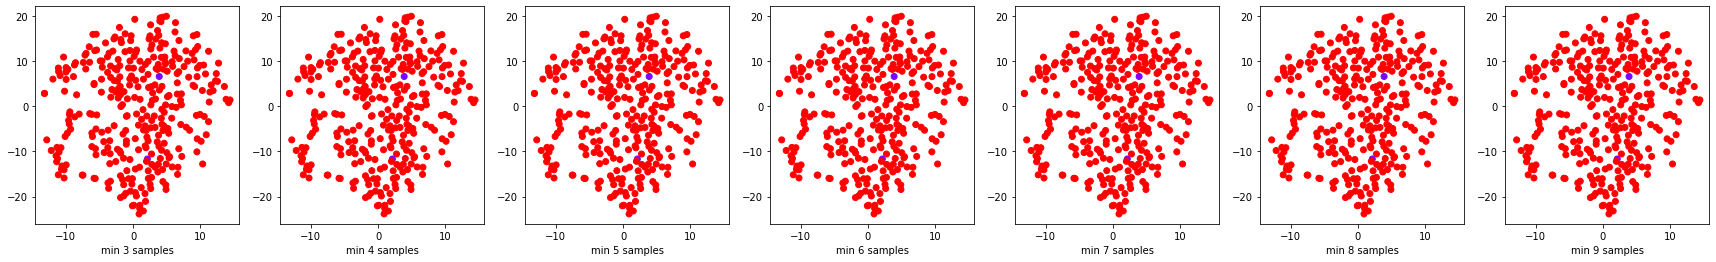

In [33]:
# Using eps from the plot
fig, axes = plt.subplots(ncols=7, figsize=(30, 4))


for idx, i in enumerate(range(3, 10)):
    dbscan = DBSCAN(metric="cosine", eps=0.36, min_samples=i)
    clusters = dbscan.fit_predict(scaled_data)

    axes[idx].set_xlabel(f"min {i} samples")
    axes[idx].scatter(
      x=data_embedded[:, 0], 
      y=data_embedded[:, 1], 
      c=clusters, 
      cmap="rainbow"
      )

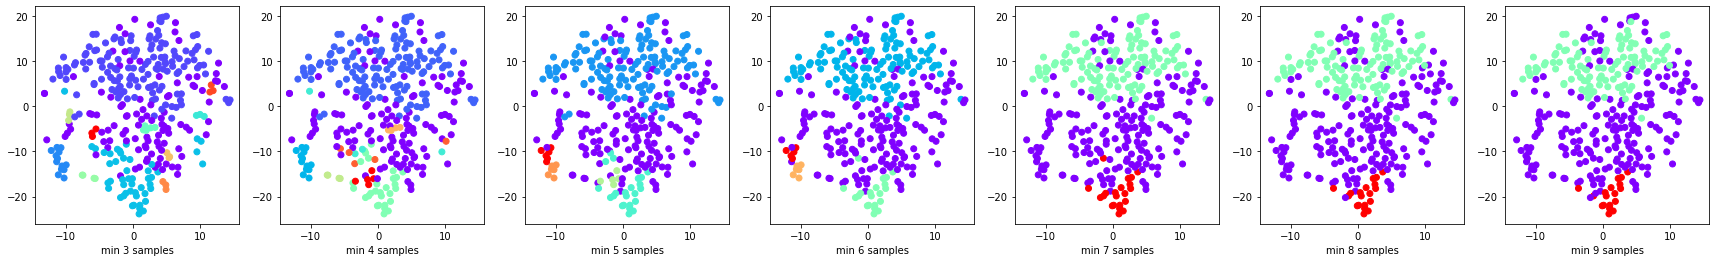

In [34]:
# Using hand-picked eps
fig, axes = plt.subplots(ncols=7, figsize=(30, 4))


for idx, i in enumerate(range(3, 10)):
    dbscan = DBSCAN(metric="cosine", eps=0.16, min_samples=i)
    clusters = dbscan.fit_predict(scaled_data)

    axes[idx].set_xlabel(f"min {i} samples")
    axes[idx].scatter(
      x=data_embedded[:, 0], 
      y=data_embedded[:, 1], 
      c=clusters, 
      cmap="rainbow"
      )

In [35]:
dbscan = DBSCAN(metric="cosine", eps=0.16, min_samples=9)
clusters = dbscan.fit_predict(scaled_data)

metric_stats["dbscan_cosine"] = compute_metrics(scaled_data, clusters)

Silhouette: 0.08862792526465896
Davies-Bouldin: 1.7962841929950921
Calinski-Harabasz: 59.72216013322556


Text(0, 0.5, 'Distance')

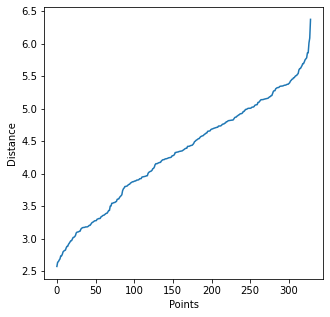

In [36]:
# Heuristics for canberra distance
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=11, metric="canberra")
neighbors = nearest_neighbors.fit(scaled_data)
distances, indices = neighbors.kneighbors(scaled_data)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

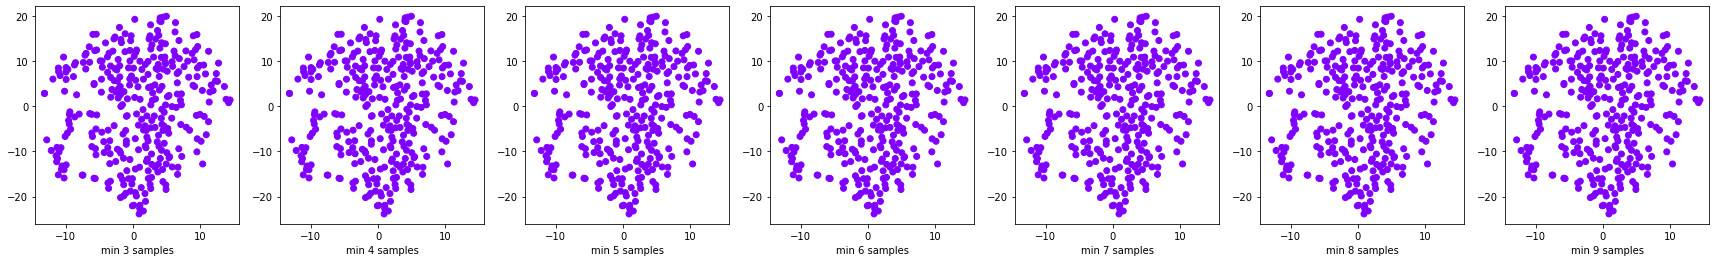

In [37]:
# Using eps from the plot
fig, axes = plt.subplots(ncols=7, figsize=(30, 4))


for idx, i in enumerate(range(3, 10)):
    dbscan = DBSCAN(metric="canberra", eps=5.5, min_samples=i)
    clusters = dbscan.fit_predict(scaled_data)

    axes[idx].set_xlabel(f"min {i} samples")
    axes[idx].scatter(
      x=data_embedded[:, 0], 
      y=data_embedded[:, 1], 
      c=clusters, 
      cmap="rainbow"
      )

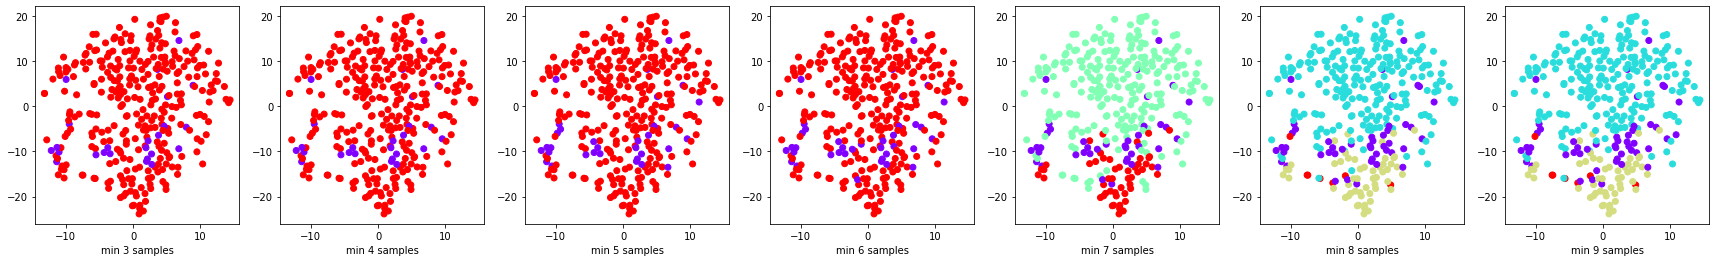

In [38]:
# Using hand-picked eps
fig, axes = plt.subplots(ncols=7, figsize=(30, 4))


for idx, i in enumerate(range(3, 10)):
    dbscan = DBSCAN(metric="canberra", eps=4.4, min_samples=i)
    clusters = dbscan.fit_predict(scaled_data)

    axes[idx].set_xlabel(f"min {i} samples")
    axes[idx].scatter(
      x=data_embedded[:, 0], 
      y=data_embedded[:, 1], 
      c=clusters, 
      cmap="rainbow"
      )

In [39]:
dbscan = DBSCAN(metric="canberra", eps=4.4, min_samples=7)
clusters = dbscan.fit_predict(scaled_data)

metric_stats["dbscan_canberra"] = compute_metrics(scaled_data, clusters)

Silhouette: 0.06696330466267836
Davies-Bouldin: 2.742753086381493
Calinski-Harabasz: 43.64947485308241


##### Заключение
- DBSCAN с подобранными с помощью эвристики оптимальными параметрами показывает достаточно плохие результаты кластеризации
- Относительно адекватные результаты он показывает, на подобранных вручную параметрах, хотя как минимум визуально они достаточно сильно отличаются от результатов кластеризации другими способами
- При использовании расстояний `cosine` и `canberra` на графике даже нет чёткого места изгиба для выбора `eps`
- В любом случае, относительно оптимальными представляются сочетания `eps=0.16 & cosine & min_samples ∈ {7,8,9}`, `eps=1.3 & euclidean & min_samples ∈ {5,6,9}`и `eps=4.4 & canberra & min_samples=7`

### KMeans

In [40]:
wss = []
n_clusters = range(1,15)
for k in n_clusters:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_data.values)
    wss.append(km.inertia_)

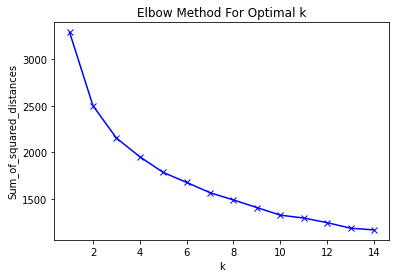

In [41]:
plt.plot(n_clusters, wss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

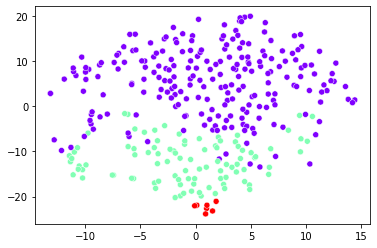

In [42]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(scaled_data.values)

plot_samples(data_embedded, clusters)

In [43]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(scaled_data.values)

metric_stats["kmeans"] = compute_metrics(scaled_data, clusters)

Silhouette: 0.2378531239217623
Davies-Bouldin: 1.5285566112731594
Calinski-Harabasz: 86.09157814257729


##### Заключение
- Оптимальное количество кластеров - 3
- Результаты кластеризации **очень** напоминают результаты аггломеративной кластеризации

### HDBSCAN

In [44]:
!pip install hdbscan --quiet

     |████████████████████████████████| 6.4MB 1.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [45]:
from hdbscan import HDBSCAN

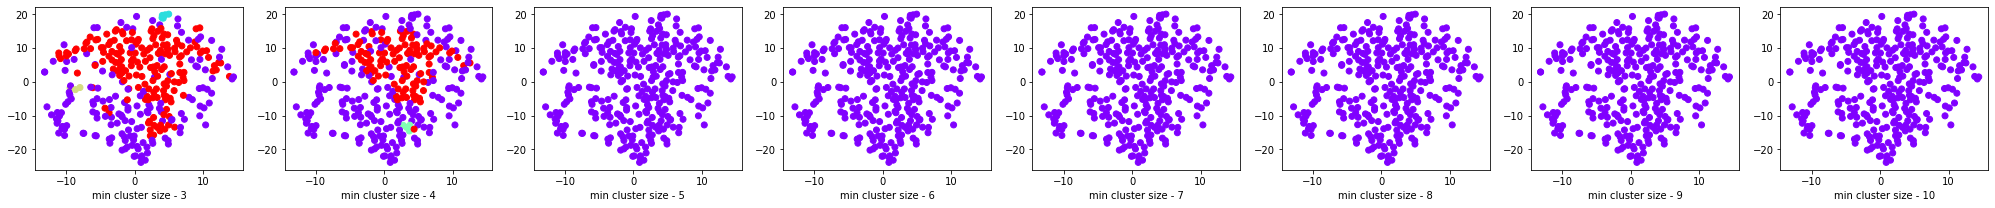

In [46]:
# choosing optimal min_cluster_size
fig, axes = plt.subplots(ncols=8, figsize=(35, 3))


for idx, i in enumerate(range(3, 11)):
    hdbscan = HDBSCAN(metric="euclidean", min_cluster_size=i)
    clusters = hdbscan.fit(scaled_data)

    axes[idx].set_xlabel(f"min cluster size - {i}")
    axes[idx].scatter(
      x=data_embedded[:, 0], 
      y=data_embedded[:, 1], 
      c=clusters.labels_, 
      cmap="rainbow"
      )

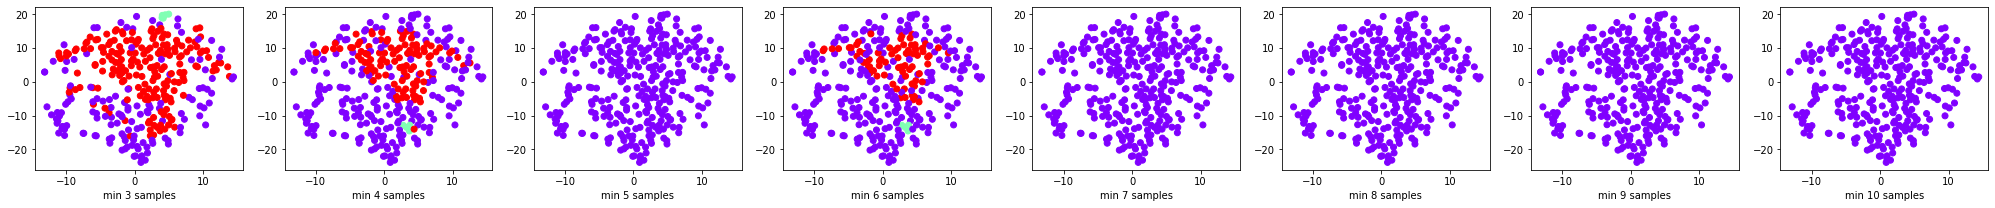

In [47]:
# choosing optimal min_samples and epsilon
fig, axes = plt.subplots(ncols=8, figsize=(35, 3))


for idx, i in enumerate(range(3, 11)):
    hdbscan = HDBSCAN(
      metric="euclidean", 
      min_cluster_size=4, 
      min_samples=i, 
      cluster_selection_epsilon=3.1
      )
    clusters = hdbscan.fit(scaled_data)

    axes[idx].set_xlabel(f"min {i} samples")
    axes[idx].scatter(
      x=data_embedded[:, 0], 
      y=data_embedded[:, 1], 
      c=clusters.labels_, 
      cmap="rainbow"
      )

In [48]:
  hdbscan = HDBSCAN(
      metric="euclidean", 
      min_cluster_size=4, 
      min_samples=3, 
      cluster_selection_epsilon=3.1
      )

clusters = hdbscan.fit(scaled_data)
metric_stats["hdbscan"] = compute_metrics(scaled_data, clusters.labels_)

Silhouette: 0.12551886836376325
Davies-Bouldin: 1.9489708574623812
Calinski-Harabasz: 27.39201136703522


##### Заключение
- Работает чуть лучше, чем обычный DBSCAN
- Но всё ещё почти не выделяет 3й кластер

### Сравнение результатов различных алгоритмов

In [49]:
metric_stats

{'agglomerative_average_cosine': Metrics(silhouette=0.08797497634337614, davies=2.0850910072225193, calinski=53.813409016452525),
 'agglomerative_complete_cosine': Metrics(silhouette=0.13931449234623647, davies=2.339718960788736, calinski=43.342180410474114),
 'agglomerative_ward': Metrics(silhouette=0.1740790530715999, davies=1.6386724367395287, calinski=72.21532753341644),
 'dbscan_canberra': Metrics(silhouette=0.06696330466267836, davies=2.742753086381493, calinski=43.64947485308241),
 'dbscan_cosine': Metrics(silhouette=0.08862792526465896, davies=1.7962841929950921, calinski=59.72216013322556),
 'dbscan_euclidean': Metrics(silhouette=0.6129352430409912, davies=0.8082913537210814, calinski=66.79375705838629),
 'hdbscan': Metrics(silhouette=0.12551886836376325, davies=1.9489708574623812, calinski=27.39201136703522),
 'kmeans': Metrics(silhouette=0.2378531239217623, davies=1.5285566112731594, calinski=86.09157814257729)}

In [50]:
print("Sorted by Calinski-Harabasz")
print("---------------------------")
print("\n".join([f"{idx}: {alg[0]} -> {alg[1].calinski}" for idx, alg in enumerate(sorted(metric_stats.items(), key=lambda k: k[1].calinski, reverse=True), 1)]))

Sorted by Calinski-Harabasz
---------------------------
1: kmeans -> 86.09157814257729
2: agglomerative_ward -> 72.21532753341644
3: dbscan_euclidean -> 66.79375705838629
4: dbscan_cosine -> 59.72216013322556
5: agglomerative_average_cosine -> 53.813409016452525
6: dbscan_canberra -> 43.64947485308241
7: agglomerative_complete_cosine -> 43.342180410474114
8: hdbscan -> 27.39201136703522


In [51]:
print("Sorted by Davies-Bouldin")
print("------------------------")
print("\n".join([f"{idx}: {alg[0]} -> {alg[1].davies}" for idx, alg in enumerate(sorted(metric_stats.items(), key=lambda k: k[1].davies), 1)]))

Sorted by Davies-Bouldin
------------------------
1: dbscan_euclidean -> 0.8082913537210814
2: kmeans -> 1.5285566112731594
3: agglomerative_ward -> 1.6386724367395287
4: dbscan_cosine -> 1.7962841929950921
5: hdbscan -> 1.9489708574623812
6: agglomerative_average_cosine -> 2.0850910072225193
7: agglomerative_complete_cosine -> 2.339718960788736
8: dbscan_canberra -> 2.742753086381493


In [52]:
print("Sorted by Silhouette")
print("--------------------")
print("\n".join([f"{idx}: {alg[0]} -> {alg[1].silhouette}" for idx, alg in enumerate(sorted(metric_stats.items(), key=lambda k: k[1].silhouette, reverse=True), 1)]))

Sorted by Silhouette
--------------------
1: dbscan_euclidean -> 0.6129352430409912
2: kmeans -> 0.2378531239217623
3: agglomerative_ward -> 0.1740790530715999
4: agglomerative_complete_cosine -> 0.13931449234623647
5: hdbscan -> 0.12551886836376325
6: dbscan_cosine -> 0.08862792526465896
7: agglomerative_average_cosine -> 0.08797497634337614
8: dbscan_canberra -> 0.06696330466267836


##### Заключение
- `dbscan_euclidean` показывает хорошие результаты на метриках, но на практике кластеризация крайне далека от идеала, кидая почти всё в один кластер (ставлю дизлайк, в общем)
- `kmeans` и `agglomerative_ward` кластеризуют достаточно адекватно и примерно одинаково
- `dbscan_canberra` отрабататывает достаточно плохо
- `hdbscan` по метрикам работает хуже, чем `dbscan`, но на практике показывает более адекватные результаты
- `kmeans` кластеризиет хорошо как по метрикам, так и на практике (отдам предпочтение ему)
- кластеризации, использующие косинусное расстояние, на практике и по метрикам показывают себя средне

### Интерпретация наилучшего метода кластеризации

<AxesSubplot:>

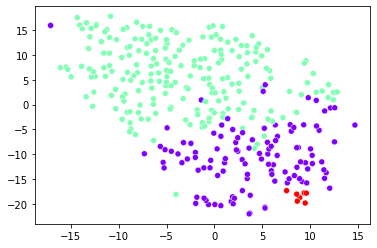

In [12]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(scaled_data.values)

plot_samples(data_embedded, clusters)

In [13]:
data["Cluster"] = clusters
data.head()

,Place,Climate,HousingCost,HlthCare,Crime,Transp,Educ,Arts,Recreat,Econ,Long,Lat,Pop,Cluster
0,"Abilene,TX",521,6200,237,923,4031,2757,996,1405,7633,-99.6890,32.5590,110932,1
1,"Akron,OH",575,8138,1656,886,4883,2438,5564,2632,4350,-81.5180,41.0850,660328,0
2,"Albany,GA",468,7339,618,970,2531,2560,237,859,5250,-84.1580,31.5750,112402,1
3,"Albany-Schenectady-Troy,NY",476,7908,1431,610,6883,3399,4655,1617,5864,-73.7983,42.7327,835880,0
4,"Albuquerque,NM",659,8393,1853,1483,6558,3026,4496,2612,5727,-106.6500,35.0830,419700,0


In [14]:
data["Cluster"].value_counts()

1    211
0    111
2      7
Name: Cluster, dtype: int64

In [15]:
data.drop(["Long", "Lat"], axis=1).groupby("Cluster").mean()

,Climate,HousingCost,HlthCare,Crime,Transp,Educ,Arts,Recreat,Econ,Pop
Cluster,,,,,,,,,,
0,588.288288,10029.945946,1724.540541,1126.153153,5096.729730,2950.693694,5048.045045,2446.036036,6068.675676,8.056767e+05
1,509.412322,7357.284360,762.810427,855.516588,3663.127962,2724.867299,1425.345972,1499.151659,5243.535545,2.145611e+05
2,636.714286,11472.428571,5390.142857,1524.285714,6637.142857,3374.857143,25080.000000,2784.142857,5405.142857,5.296353e+06


##### Заключение
- В самом малочисленном кластере в среднем климат, уровень здравоохранения, образования, транспорта, искусства и бизнеса в сфере отдыха лучше, чем в городах из других кластеров
- В этом же кластере самые дорогие дома, но при этом и самый высокий уровень преступности
- Уровень развития сферы искусства **гораздо** выше, чем в городах из других кластеров
- Уровень развития экономики во всех кластерах не особо сильное отличается
---
- В самом многочисленном кластере климат занимает среднее положение между двумя другими, цена недвижимости в нём прилично меньше, чем в городах из других кластеров
- Хотя уровень преступности в нём тоже гораздо меньше, чем в городах из других кластеров, уровень здравоохранения тоже хромает
- Уровень развития транспортной системы, системы образования, бизнеса в сфере рекреации и искусства достаточно сильно отстают от других городов
---
- В первом по численности кластере стоимость недвижимости почти достигает уровня наименее численного, при этом пропорции в уровне преступности между ними также сохраняются
- Уровень развития здравоохранения ощутимо ниже, чем в самом малочисленном кластере, уровни развития транспортной системы, системы образования, искусства также ниже
- Уровень экономики и бизнеса в сфере рекреационных услуг находится примерно на том же уровне
---
Выводы:
- Самый малочисленный кластер может быть каким-то элитным регионом, в котором, на удивление, не самый низкий уровень преступности. Возможно, это связано с тем, что в этом регионе достаточно сильный межклассовый разрыв
- Второй по численности кластер представляет собой средний город со своими проблемами, но достаточно низким уровнем преступности
- Самый многочисленный кластер представляет собой набор достаточно крупных городов (судя по стоимости жилья), которые отстают от элитных, но поддерживают достаточно хороший уровень жизни у своего населения



### Географическое распределение кластеров

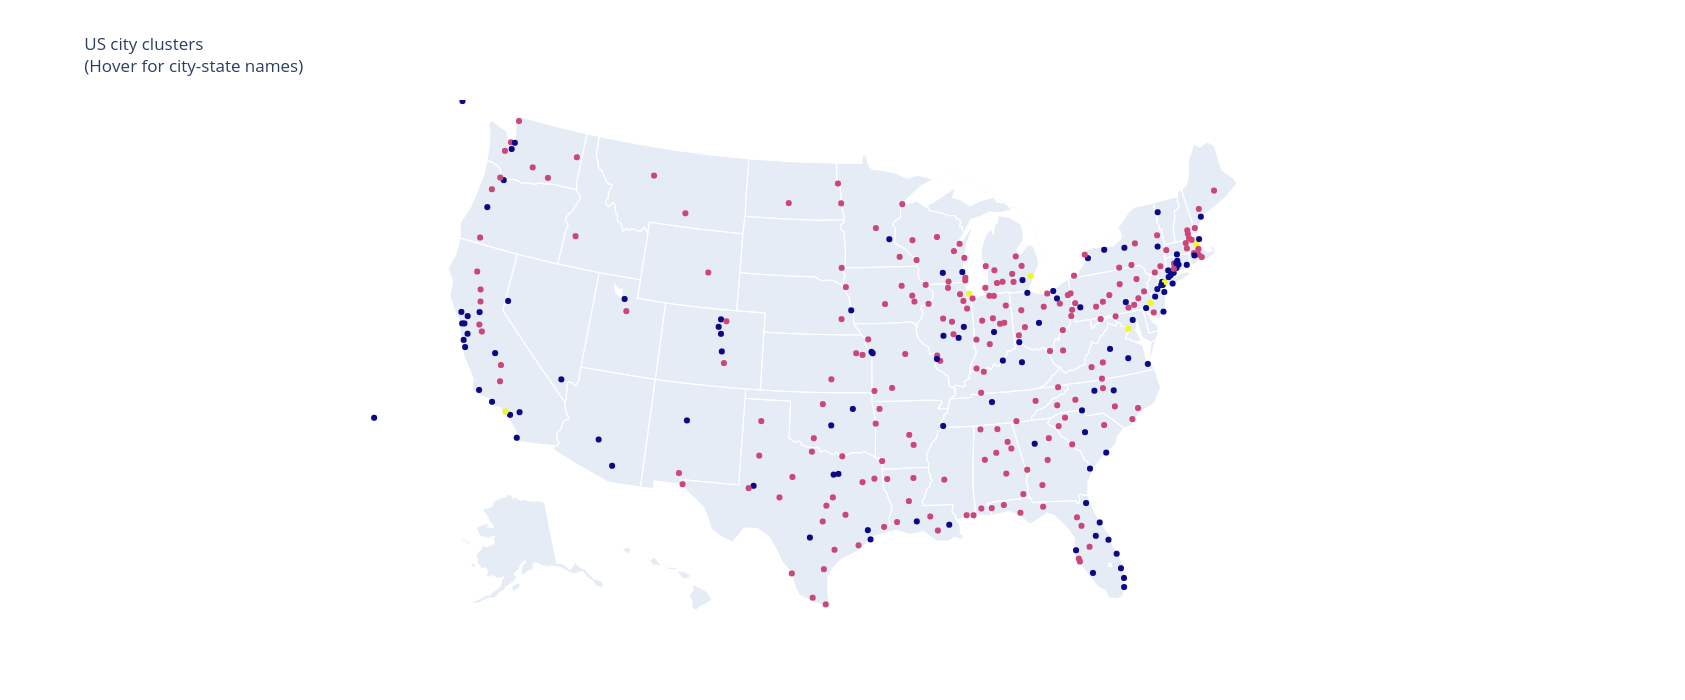

In [29]:
import plotly.graph_objects as go
import plotly.offline as py

fig = go.FigureWidget(data=go.Scattergeo(
        lon = data['Long'],
        lat = data['Lat'],
        text = data['Place'],
        mode = 'markers',
        marker_color = data['Cluster'],
        ))

fig.update_layout(
        title = 'US city clusters<br>(Hover for city-state names)',
        geo_scope='usa',
        width=1400,
        height=700,
        autosize=False
    )

fig.show(renderer="jupyterlab")

##### Заключение
- Самые дорогие дома, как правило, находятся недалеко от побережья
- Дома из второго по численности кластера тоже иногда расположены у побережья, но часто это просто достаточно крупные города, разбросанные по территории США
- Дома из самого многочисленного кластера представляют собой среднестатистические города (часто в крупных скоплениях в одном и том же штате)